In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
data_path = f"{path}/brain_tumor_dataset/"

In [ ]:
!ls {data_path}

no  yes


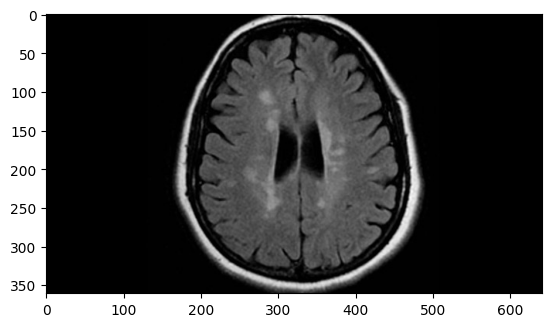

In [ ]:
img = mpimg.imread(f"{data_path}no/no 8.jpg")
plt.imshow(img)

In [ ]:
tf.random.set_seed(42)
generator = ImageDataGenerator(rescale = 1./255.,
                              validation_split=0.8,
                              horizontal_flip=True,
                              vertical_flip=False,
                              zoom_range=0.05,
                              rotation_range=25)

In [ ]:
train_data = generator.flow_from_directory(data_path,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

test_data = generator.flow_from_directory(data_path,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


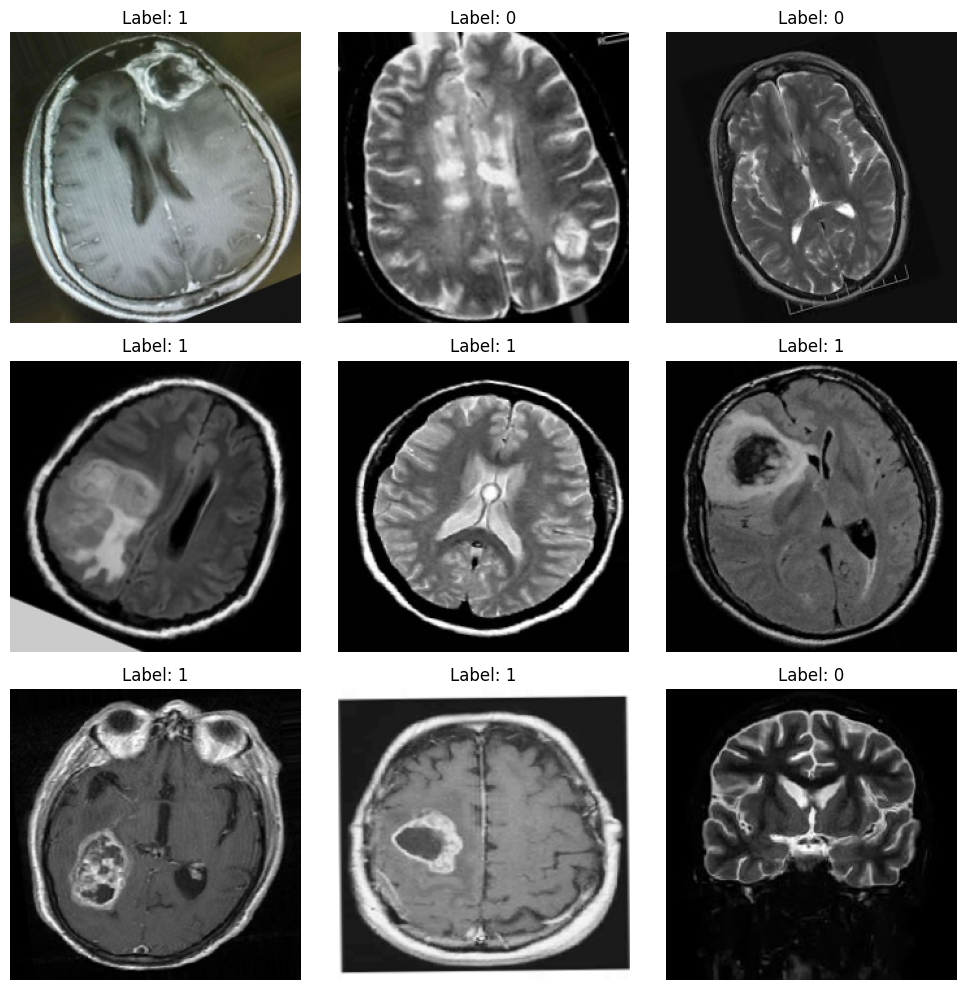

In [ ]:

# Get one batch of images and labels
images, labels = next(train_data)

# Show the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), padding="valid"))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

print(model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 220, 220, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 108, 108, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 89888)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │    11,505,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,552,865 (44.07 MB)

 Trainable params: 11,552,865 (44.07 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=7,          # stop if no improvement after 7 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,          # reduce LR by 20%
    patience=3,          # wait 3 epochs before reducing
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model_brain_tumor_class.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Fit model
model_history2 = model.fit(
    train_data,
    epochs=100,   # increased from 50 to 100
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[earlystop, reduce_lr, checkpoint]
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5135 - loss: 0.7073
Epoch 1: val_loss improved from inf to 0.64091, saving model to best_model_brain_tumor_class.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5184 - loss: 0.7052 - val_accuracy: 0.6126 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6761 - loss: 0.6068
Epoch 2: val_loss improved from 0.64091 to 0.59982, saving model to best_model_brain_tumor_class.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6739 - loss: 0.6092 - val_accuracy: 0.7787 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6728 - loss: 0.5876
Epoch 3: val_loss improved from 0.59982 to 0.56968, saving model to best_model_brain_tumor_class.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6736 - loss: 0.5871 - val_accuracy: 0.7628 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9730 - loss: 0.0952


[0.1274084746837616, 0.9525691866874695]

In [ ]:
model.save("/content/drive/MyDrive/best_model_brain_tumor_classification_val_0.973.keras")

<Axes: >

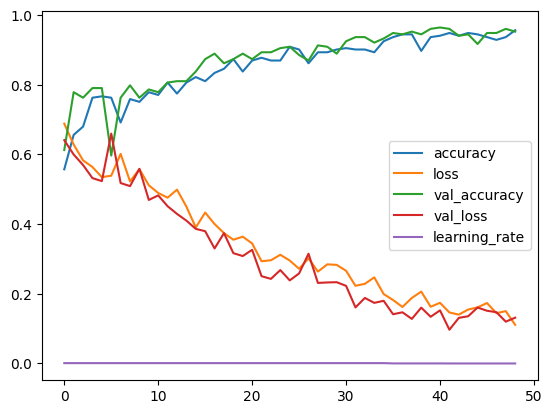

In [ ]:
pd.DataFrame(model_history2.history).plot()